In [1]:
# Run the pip install command below if you don't already have the library
# !pip install git+https://github.com/JustAnotherArchivist/snscrape.git

import os
import math
import pandas as pd
import json
from pandas import json_normalize

import snscrape.modules.twitter as sntwitter
import itertools

from datetime import datetime
from random import randrange
import shutil

In [3]:
# Search terms: Content in the tweet
search_terms = [
    'coronavirus',
    'covid19',
    'pandemic',
    'quarantine',
]

# Testing additional Search Terms in Tweet Content Field. 
search_terms_two = [
    'vaxx',
    'unvaxxed'
    'antivaccine'
    'nomask',
    'maskoff',
    'masksdontwork',
]

# Creates a search parameter for the Twitter scraper
# since_date: inclusive
# until_date: exclusive
def search_builder(terms, area, since_date, until_date):    
    s = ''
    # Concatenate all search terms
    for i in range(len(terms) - 1):
        # NOTE: Inclusive OR statement
        s += '\"' + terms[i] + '\" OR '
    s += '\"' + terms[len(terms) - 1] + '\" '    
    
    # Within or the near the area
    s += 'near:\"' + area + '\" '
    # Since the first date
    s += 'since:' + since_date + ' '
    # Until the second date
    s += 'until:' + until_date
    
    return s

# Returns a DataFrame with at most tweet_limit tweets resulting from
# the search
def scrape(search_param, tweet_limit):
    return pd.DataFrame(itertools.islice(
        sntwitter.TwitterSearchScraper(search_param).get_items(), tweet_limit))

# Search for tweets in Los Angeles mentioning COVID terms
# from the beginning to the end of 2020.
los_angeles_search = search_builder(
    search_terms,
    "Los Angeles",
    '2020-01-01',
    '2020-12-31')

print(los_angeles_search)

"coronavirus" OR "covid19" OR "pandemic" OR "quarantine" near:"Los Angeles" since:2020-01-01 until:2020-12-31


In [3]:
# ********* STATE TWEET SCRAPING *********

def state_scraper(state, abbr, limit, since_date, until_date):

    total_tweets = 0

    print("Compiling tweets (max <=" + str(limit) + ") from " + state + " counties from " + since_date + " to " + until_date)

    print("START: " + str(datetime.now()))

    counties = pd.read_csv("data/counties/" + abbr + "_counties.csv")

    for i in range(len(counties)):

        county = counties.iloc[i]['County']
        county.strip()
        
        county_search = search_builder(
            # CHANGE TO COUNTY SEARCH TERMS HERE!!!
            #search_terms,
            # search_terms -> search_terms_two
            search_terms_two,
            # CHANGE TO COUNTY SEARCH TERMS HERE!!!
            county + " County, " + abbr,
            since_date,
            until_date)

        county_tweets = scrape(county_search, limit)

        total_tweets = total_tweets + len(county_tweets)

        # Generates JSON with respective county tweet data
        county_json = county_tweets.to_json(county + ".json", lines=True, orient='records')

        source = os.getcwd() + "/" + county + ".json"
        destination = os.getcwd() + "/data/tweets/" + abbr + "_tweets/" + county + ".json"
        shutil.move(source, destination)

        print("(" + str(i + 1) + "/" + str(len(counties)) + ") " + county + " - " + str(len(county_tweets)) + " tweets: " + str(datetime.now()))

    print("END: " + str(datetime.now()))
    print(str(total_tweets) + " tweets processed")

    
# California Tweet Scraper
def ca_scraper(tweet_limit, since_date, until_date):
    state_scraper("California", "CA", tweet_limit, since_date, until_date)

# Florida Tweet Scraper
def fl_scraper(tweet_limit, since_date, until_date):
    state_scraper("Florida", "FL", tweet_limit, since_date, until_date)

# New York Tweet Scraper
def ny_scraper(tweet_limit, since_date, until_date):
    state_scraper("New York", "NY", tweet_limit, since_date, until_date)
    
# Texas Tweet Scraper
def tx_scraper(tweet_limit, since_date, until_date):
    state_scraper("Texas", "TX", tweet_limit, since_date, until_date)

In [4]:
# Branch-2-Keywords Testing new search terms 
ca_scraper(100, "2021-10-17", "2021-10-23")

Compiling tweets (max <=100) from California counties from 2021-10-17 to 2021-10-23
START: 2021-11-21 15:49:48.045074
(1/58) Alameda - 0 tweets: 2021-11-21 15:49:50.445587
(2/58) Alpine - 100 tweets: 2021-11-21 15:49:53.958380
(3/58) Amador - 0 tweets: 2021-11-21 15:49:55.819109
(4/58) Butte - 0 tweets: 2021-11-21 15:49:57.182425
(5/58) Calaveras - 0 tweets: 2021-11-21 15:49:58.439467
(6/58) Colusa - 100 tweets: 2021-11-21 15:50:01.730124
(7/58) Contra Costa - 1 tweets: 2021-11-21 15:50:03.280607
(8/58) Del Norte - 0 tweets: 2021-11-21 15:50:04.577113
(9/58) El Dorado - 0 tweets: 2021-11-21 15:50:05.783763
(10/58) Fresno - 0 tweets: 2021-11-21 15:50:07.054477
(11/58) Glenn - 100 tweets: 2021-11-21 15:50:10.025945
(12/58) Humboldt - 0 tweets: 2021-11-21 15:50:11.223873
(13/58) Imperial - 0 tweets: 2021-11-21 15:50:12.685747
(14/58) Inyo - 100 tweets: 2021-11-21 15:50:15.862221
(15/58) Kern - 0 tweets: 2021-11-21 15:50:17.215765
(16/58) Kings - 0 tweets: 2021-11-21 15:50:18.581194
(17/58

In [4]:
# Branch-2-Keywords testing json to pandas dataframes
import re
# Code taken from Professor Mahdi slides. [Should update which slides this is from later.]
def clean_content(content_line):
    digit_removal = re.sub('\d+', '', content_line)
    punctuation_removal = re.sub('[\W]+', ' ', digit_removal)
    return punctuation_removal.upper().split()  

def file_paths(path):
    # Stack overflow solution to finding only files in a directory using os.walk, previous attempt used listdir.
    # Article: https://stackoverflow.com/questions/52338706/isadirectoryerror-errno-21-is-a-directory-it-is-a-file
    path_list = [os.path.join(path, file) 
                      for path, directory, files in os.walk(path) for file in files]
    return path_list

# Combine JSON files for efficiency then make a single dataframe.

# Take tweet from tweet folder.
# json_folder_path is the folder path containing the json files like ca_tweets.
def json_to_dataFrame(json_folder_path):
    file_path_list = file_paths(json_folder_path)
    combined_json_file = 'data/tweets/result.json'
# Stack overflow solution for combining json files. Combining json files was suggested as more efficient than
#  dataframes. Combines the json files into record oreint/format. 
# Article: https://stackoverflow.com/questions/23520542/issue-with-merging-multiple-json-files-in-python
    with open(combined_json_file, 'w') as combined_files:
        combined_files.write("{}".format("".join([open(file, "r").read() for file in file_path_list])))
# Dataframe using orient records because this was the specific formating used to collect the data. 
    dataframe = pd.read_json(combined_json_file, lines=True, orient='records')
# Cleans data by stripping potentially unnececary information. 
    clean_df = dataframe.drop(['url', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount', 
                                 'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel',
                                 'outlinks', 'tcooutlinks','media','retweetedTweet', 'quotedTweet', 
                                 'inReplyToTweetId', 'inReplyToUser', 'mentionedUsers'], axis=1)
    return clean_df


ca_df = json_to_dataFrame('data/tweets/ca_tweets')

ca_df

,date,content,renderedContent,id,user,coordinates,place,hashtags,cashtags
0,2021-10-22 23:59:58,@McBill54 @zurent @ReutersFacts 6.7 million pe...,@McBill54 @zurent @ReutersFacts 6.7 million pe...,1451699883799367682,"{'username': 'BostonBubbalooo', 'id': 86396386...",None,None,None,None
1,2021-10-22 23:59:22,@Theo_TJ_Jordan The point of lockdowns was nev...,@Theo_TJ_Jordan The point of lockdowns was nev...,1451699735253897216,"{'username': 'FPphilosopher', 'id': 567666754,...",None,None,None,None
2,2021-10-22 23:58:53,@April39677298 @KatieDaviscourt The way things...,@April39677298 @KatieDaviscourt The way things...,1451699612427952133,"{'username': 'velara3', 'id': 15928093, 'displ...",None,None,[notantivaxx],None
3,2021-10-22 23:57:50,@FurnessColin @ccleighton I Disagree. Interest...,@FurnessColin @ccleighton I Disagree. Interest...,1451699346974683139,"{'username': 'vickyrobinbaum', 'id': 106681695...",None,None,None,None
4,2021-10-22 23:57:34,@Richard89501125 @fisherman0707 @Dan_GT2 The v...,@Richard89501125 @fisherman0707 @Dan_GT2 The v...,1451699281119772674,"{'username': 'RobAllan4', 'id': 10976255921223...",None,None,None,None
...,...,...,...,...,...,...,...,...,...
1104,2021-10-22 23:22:55,"@seanhannity Tell me again, how can Cops who d...","@seanhannity Tell me again, how can Cops who d...",1451690559295401984,"{'username': 'fearlesshyna123', 'id': 48337003...",None,None,None,None
1105,2021-10-22 23:22:40,"So let me get this straight, people will lose ...","So let me get this straight, people will lose ...",1451690499715256320,"{'username': 'PierogiDuck', 'id': 143815654369...",None,None,None,None
1106,2021-10-18 23:52:22,Since they are still pontificating about my co...,Since they are still pontificating about my co...,1450248422838059008,"{'username': 'howtomakeloot', 'id': 1066977135...","{'longitude': -118.4859540499, 'latitude': 34....","{'fullName': 'Starbucks', 'name': 'Starbucks',...","[nofucksgiven, payforplay, sameolesameole]",None
1107,2021-10-17 01:48:22,@robintran04 Dexter except he kills people for...,@robintran04 Dexter except he kills people for...,1449552837503963139,"{'username': 'bmkibler', 'id': 18995373, 'disp...","{'longitude': -118.37032, 'latitude': 34.1426298}","{'fullName': 'Burbank, CA', 'name': 'Burbank',...",None,None


In [5]:
# Sentiment testing with HuggingFace
# Pip install the transfomers with Pytorch specifically. 
# !pip install transformers[torch]
from transformers import pipeline

def sentiment_analysis(dataframe):
    # Construct pipeline using sentiment-analysis to mesaure "sentiment" of tweet content
    classifier = pipeline("sentiment-analysis")

    # Create empty list to collect sentiment values
    sentiment_list = []
    # For loop to take twitter content and analyze for sentiment values.
    for content in ca_df['content']:
        content_sentiment = classifier(content)
#         # Format sentiment score
#         content_sentiment[0]['score'] = "{:.2f}%".format(content_sentiment[0]['score'] * 100)
#         # Append each new content sentiment to the list.
#         sentiment_list.append(content_sentiment[0])
        sentiment_list.append(content_sentiment[0]['label'])
        
    # Copy dataframe
    df_copy = dataframe.copy()
    # Drop additional infromation for easier view of data
    # DELETE LINE BELOW FOR THE DATA IT DROPS
    df_copy = df_copy.drop(['id', 'coordinates', 'place', 'hashtags', 'cashtags'], axis=1)
    # assign the new sentiment list values to the dataframe titled sentiment
    return df_copy.assign(sentiment = sentiment_list)

test_ca_df = sentiment_analysis(ca_df)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [34]:
# Showcase new DF
# test_ca_df1 = test_ca_df['date'].splice_replace(0,9, '')
test_ca_df['date'][0].replace(hour=0, minute=0, second=0)

Timestamp('2021-10-22 00:00:00')

In [7]:
# Testing how many tweets were identified as 'positive' which may be an interesting insight to the accuracy of the 
#  sentiment analysis. Compare the content to ensure true positive sentiment and not sarcastic senitments.
test_ca_df.loc[test_ca_df['sentiment']=='POSITIVE']

,date,content,renderedContent,user,sentiment
3,2021-10-22 23:57:50,@FurnessColin @ccleighton I Disagree. Interest...,@FurnessColin @ccleighton I Disagree. Interest...,"{'username': 'vickyrobinbaum', 'id': 106681695...",POSITIVE
25,2021-10-22 23:51:16,"@ConceptualJames That is probably right, becau...","@ConceptualJames That is probably right, becau...","{'username': 'PeterTobias8', 'id': 84330874901...",POSITIVE
26,2021-10-22 23:51:11,@doms_tru_news @SNAUFootball To me these comme...,@doms_tru_news @SNAUFootball To me these comme...,"{'username': 'FacePlantt44', 'id': 14188969374...",POSITIVE
53,2021-10-22 23:42:52,Anti-vaxx Chronicles: Meet the Qanon poet http...,Anti-vaxx Chronicles: Meet the Qanon poet dail...,"{'username': '508gloryFelix', 'id': 7960344572...",POSITIVE
56,2021-10-22 23:41:34,Not reporting NEGATIVE news gives everyone a s...,Not reporting NEGATIVE news gives everyone a s...,"{'username': 'stocktrades7777', 'id': 22332950...",POSITIVE
...,...,...,...,...,...
1062,2021-10-22 23:41:34,Not reporting NEGATIVE news gives everyone a s...,Not reporting NEGATIVE news gives everyone a s...,"{'username': 'stocktrades7777', 'id': 22332950...",POSITIVE
1070,2021-10-22 23:38:41,@Ldonahuehjelle Vaxx mandates are providing an...,@Ldonahuehjelle Vaxx mandates are providing an...,"{'username': 'GlennPh73983526', 'id': 12809694...",POSITIVE
1079,2021-10-22 23:35:20,@SunnySide1984 @_Serene_96 @thehill Ben Shapir...,@SunnySide1984 @_Serene_96 @thehill Ben Shapir...,"{'username': 'AuburnDr', 'id': 2174337811, 'di...",POSITIVE
1080,2021-10-22 23:34:37,@Raina061983 @KikiBeatz416 @CP24 This is so tr...,@Raina061983 @KikiBeatz416 @CP24 This is so tr...,"{'username': 'Cindy74325088', 'id': 1395929731...",POSITIVE


In [11]:
test_ca_df

,date,content,renderedContent,user,sentiment
0,2021-10-22 23:59:58,@McBill54 @zurent @ReutersFacts 6.7 million pe...,@McBill54 @zurent @ReutersFacts 6.7 million pe...,"{'username': 'BostonBubbalooo', 'id': 86396386...",NEGATIVE
1,2021-10-22 23:59:22,@Theo_TJ_Jordan The point of lockdowns was nev...,@Theo_TJ_Jordan The point of lockdowns was nev...,"{'username': 'FPphilosopher', 'id': 567666754,...",NEGATIVE
2,2021-10-22 23:58:53,@April39677298 @KatieDaviscourt The way things...,@April39677298 @KatieDaviscourt The way things...,"{'username': 'velara3', 'id': 15928093, 'displ...",NEGATIVE
3,2021-10-22 23:57:50,@FurnessColin @ccleighton I Disagree. Interest...,@FurnessColin @ccleighton I Disagree. Interest...,"{'username': 'vickyrobinbaum', 'id': 106681695...",POSITIVE
4,2021-10-22 23:57:34,@Richard89501125 @fisherman0707 @Dan_GT2 The v...,@Richard89501125 @fisherman0707 @Dan_GT2 The v...,"{'username': 'RobAllan4', 'id': 10976255921223...",NEGATIVE
...,...,...,...,...,...
1104,2021-10-22 23:22:55,"@seanhannity Tell me again, how can Cops who d...","@seanhannity Tell me again, how can Cops who d...","{'username': 'fearlesshyna123', 'id': 48337003...",NEGATIVE
1105,2021-10-22 23:22:40,"So let me get this straight, people will lose ...","So let me get this straight, people will lose ...","{'username': 'PierogiDuck', 'id': 143815654369...",NEGATIVE
1106,2021-10-18 23:52:22,Since they are still pontificating about my co...,Since they are still pontificating about my co...,"{'username': 'howtomakeloot', 'id': 1066977135...",NEGATIVE
1107,2021-10-17 01:48:22,@robintran04 Dexter except he kills people for...,@robintran04 Dexter except he kills people for...,"{'username': 'bmkibler', 'id': 18995373, 'disp...",NEGATIVE


In [8]:
# Attempt at Loading Covid-19 data
# Load California Covid 19 Vaccination data by county
ca_covid_df = pd.read_csv("data/covid_data/covid19vaccinesbycounty.csv")
# Drop majority of columns 
ca_covid_df = ca_covid_df.drop(['pfizer_doses', 'cumulative_pfizer_doses', 'moderna_doses', 
                                'cumulative_moderna_doses', 'jj_doses', 'cumulative_jj_doses', 
                                'partially_vaccinated', 'total_partially_vaccinated','california_flag'], axis=1)
# Select specific data based on time frames
ca_covid_df[ca_covid_df['administered_date'].isin(['2021-10-17', '2021-10-23'])].loc[ca_covid_df['county'] 
                                                                                     == 'All CA Counties']
# Test graphical output of matplotlib... 

,county,administered_date,total_doses,cumulative_total_doses,fully_vaccinated,cumulative_fully_vaccinated,at_least_one_dose,cumulative_at_least_one_dose,booster_recip_count,cumulative_booster_recip_count
525,All CA Counties,2021-10-17,29761,50796146,8662,24209281,8795,26682344,12625,1526037
531,All CA Counties,2021-10-23,90887,51422897,16612,24351679,15765,26811224,59462,1892700


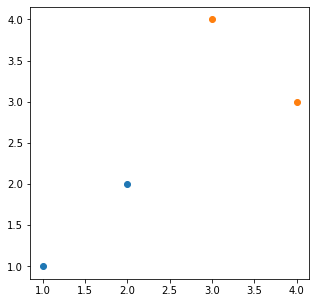

In [10]:
import matplotlib.pyplot as plt

x_axis = [1, 2]
y_axis = [1, 2]

x_axis1 = [3, 4]
y_axis1 = [4, 3]
plt.figure(figsize=(5,5))
plt.scatter(x_axis, y_axis)
plt.scatter(x_axis1, y_axis1)

In [72]:
ca_scraper(1000, "2021-10-01", "2021-10-09")

Compiling tweets (max <=1000) from California counties from 2021-10-01 to 2021-10-09
START: 2021-10-25 13:38:44.341007
(1/58) Alameda - 21 tweets: 2021-10-25 13:38:45.881042
(2/58) Alpine - 1000 tweets: 2021-10-25 13:39:09.837050
(3/58) Amador - 0 tweets: 2021-10-25 13:39:11.102162
(4/58) Butte - 1 tweets: 2021-10-25 13:39:12.396181
(5/58) Calaveras - 0 tweets: 2021-10-25 13:39:13.496967
(6/58) Colusa - 1000 tweets: 2021-10-25 13:39:36.111556
(7/58) Contra Costa - 19 tweets: 2021-10-25 13:39:37.566732
(8/58) Del Norte - 0 tweets: 2021-10-25 13:39:38.720221
(9/58) El Dorado - 0 tweets: 2021-10-25 13:39:39.831705
(10/58) Fresno - 7 tweets: 2021-10-25 13:39:41.169946
(11/58) Glenn - 1000 tweets: 2021-10-25 13:40:02.603418
(12/58) Humboldt - 3 tweets: 2021-10-25 13:40:03.850985
(13/58) Imperial - 0 tweets: 2021-10-25 13:40:05.220279
(14/58) Inyo - 1000 tweets: 2021-10-25 13:40:27.310050
(15/58) Kern - 0 tweets: 2021-10-25 13:40:28.652667
(16/58) Kings - 0 tweets: 2021-10-25 13:40:29.886437

In [73]:
fl_scraper(1000, "2021-10-01", "2021-10-09")

Compiling tweets (max <=1000) from Florida counties from 2021-10-01 to 2021-10-09
START: 2021-10-25 13:43:53.069049
(1/67) Alachua - 2 tweets: 2021-10-25 13:43:54.396436
(2/67) Baker - 0 tweets: 2021-10-25 13:43:55.864294
(3/67) Bay - 3 tweets: 2021-10-25 13:43:57.095982
(4/67) Bradford - 2 tweets: 2021-10-25 13:43:58.506500
(5/67) Brevard - 2 tweets: 2021-10-25 13:43:59.989494
(6/67) Broward - 27 tweets: 2021-10-25 13:44:02.865191
(7/67) Calhoun - 0 tweets: 2021-10-25 13:44:04.075572
(8/67) Charlotte - 1 tweets: 2021-10-25 13:44:06.441782
(9/67) Citrus - 1 tweets: 2021-10-25 13:44:07.913851
(10/67) Clay - 3 tweets: 2021-10-25 13:44:09.322266
(11/67) Collier - 4 tweets: 2021-10-25 13:44:11.197192
(12/67) Columbia - 0 tweets: 2021-10-25 13:44:12.497461
(13/67) De Soto - 1000 tweets: 2021-10-25 13:44:33.972711
(14/67) Dixie - 0 tweets: 2021-10-25 13:44:35.301368
(15/67) Duval - 1 tweets: 2021-10-25 13:44:36.607138
(16/67) Escambia - 0 tweets: 2021-10-25 13:44:38.432001
(17/67) Flagler - 

In [74]:
ny_scraper(1000, "2021-10-01", "2021-10-09")

Compiling tweets (max <=1000) from New York counties from 2021-10-01 to 2021-10-09
START: 2021-10-25 13:50:47.127010
(1/62) Albany - 2 tweets: 2021-10-25 13:50:48.532453
(2/62) Allegany - 0 tweets: 2021-10-25 13:50:50.087874
(3/62) Bronx - 415 tweets: 2021-10-25 13:51:09.882069
(4/62) Broome - 0 tweets: 2021-10-25 13:51:11.929999
(5/62) Cattaraugus - 1000 tweets: 2021-10-25 13:51:33.535964
(6/62) Cayuga - 1000 tweets: 2021-10-25 13:51:54.554562
(7/62) Chautauqua - 1 tweets: 2021-10-25 13:51:55.916112
(8/62) Chemung - 1000 tweets: 2021-10-25 13:52:17.777283
(9/62) Chenango - 1000 tweets: 2021-10-25 13:52:39.533305
(10/62) Clinton - 0 tweets: 2021-10-25 13:52:40.740557
(11/62) Columbia - 0 tweets: 2021-10-25 13:52:42.837750
(12/62) Cortland - 0 tweets: 2021-10-25 13:52:44.629477
(13/62) Delaware - 0 tweets: 2021-10-25 13:52:45.941733
(14/62) Dutchess - 6 tweets: 2021-10-25 13:52:47.189758
(15/62) Erie - 11 tweets: 2021-10-25 13:52:48.804933
(16/62) Essex - 1000 tweets: 2021-10-25 13:53:1

In [75]:
tx_scraper(1000, "2021-10-01", "2021-10-09")

Compiling tweets (max <=1000) from Texas counties from 2021-10-01 to 2021-10-09
START: 2021-10-25 13:58:00.572143
(1/254) Anderson - 1000 tweets: 2021-10-25 13:58:22.811629
(2/254) Andrews - 1000 tweets: 2021-10-25 13:58:45.415645
(3/254) Angelina - 1000 tweets: 2021-10-25 13:59:07.836704
(4/254) Aransas - 1000 tweets: 2021-10-25 13:59:29.363299
(5/254) Archer - 1000 tweets: 2021-10-25 13:59:50.296295
(6/254) Armstrong - 1000 tweets: 2021-10-25 14:00:12.225854
(7/254) Atascosa - 1000 tweets: 2021-10-25 14:00:45.014286
(8/254) Austin - 1000 tweets: 2021-10-25 14:01:06.418058
(9/254) Bailey - 1000 tweets: 2021-10-25 14:01:27.649272
(10/254) Bandera - 1000 tweets: 2021-10-25 14:01:48.893844
(11/254) Bastrop - 0 tweets: 2021-10-25 14:01:51.990935
(12/254) Baylor - 1000 tweets: 2021-10-25 14:02:13.239977
(13/254) Bee - 1000 tweets: 2021-10-25 14:02:34.524332
(14/254) Bell - 3 tweets: 2021-10-25 14:02:36.519826
(15/254) Bexar - 33 tweets: 2021-10-25 14:02:38.871012
(16/254) Blanco - 1000 twe

(140/254) Lamb - 1000 tweets: 2021-10-25 14:38:49.309231
(141/254) Lampasas - 1000 tweets: 2021-10-25 14:39:10.762286
(142/254) La Salle - 1000 tweets: 2021-10-25 14:39:32.756414
(143/254) Lavaca - 1000 tweets: 2021-10-25 14:39:53.370343
(144/254) Lee - 1000 tweets: 2021-10-25 14:40:15.248813
(145/254) Leon - 1000 tweets: 2021-10-25 14:40:37.113497
(146/254) Liberty - 0 tweets: 2021-10-25 14:40:40.910772
(147/254) Limestone - 0 tweets: 2021-10-25 14:40:42.102977
(148/254) Lipscomb - 1000 tweets: 2021-10-25 14:41:04.252068
(149/254) Live Oak - 1000 tweets: 2021-10-25 14:41:26.000914
(150/254) Llano - 1000 tweets: 2021-10-25 14:41:48.170697
(151/254) Loving - 0 tweets: 2021-10-25 14:41:49.349953
(152/254) Lubbock - 1000 tweets: 2021-10-25 14:42:10.793298
(153/254) Lynn - 1000 tweets: 2021-10-25 14:42:32.583014
(154/254) Madison - 1000 tweets: 2021-10-25 14:42:54.320934
(155/254) Marion - 1000 tweets: 2021-10-25 14:43:16.667794
(156/254) Martin - 0 tweets: 2021-10-25 14:43:18.060368
(157/

# References

California Counties: https://www.mapsofworld.com/usa/states/california/california-county-map.html

Florida Counties: https://www.mapsofworld.com/usa/states/florida/florida-county-map.html

New York Counties: https://www.mapsofworld.com/usa/states/new-york/new-york-county-map.html

Texas Counties: https://www.mapsofworld.com/usa/states/texas/texas-county-map.html